# Identifikacija moždane aktivnosti iz EEG snimaka

## Sadržaj:  
* [Uvod i motivacija](#uvod)
* [Podaci](#podaci)
* [Priprema podataka](#priprema)
* [Klasifikacione metode](#metode)
* [kNN algoritam](#knn)
* [Konvolutivne neuronske mreže](#cnn)
* [Rezultati](#rezultati)
* [Zaključak](#zaključak)
* [Literatura](#ref)

## Uvod i motivacija  <a class="anchor" id="uvod"></a>

Epilepsija, jedno od najčešćih neuroloških stanja koje karakterišu epileptični napadi, drugi je najčešći neurološki poremećaj iza moždanog udara i pogađa oko pedeset miliona ljudi prema podacima Svetske zdravstvene organizacije (SZO). Mogu se pojaviti napadi bez obzira na okolnosti ili atribute osobe. Pacijenti sa epilepsijom pate od iznenadnih i nepredviđenih napada tokom kojih su podložni gušenju, smrti ili povredama. Do danas se ova bolest uglavnom leči lekovima i hirurškim zahvatima, ali jos uvek ne postoji lek.  
Elektroencefalografija (EEG) igra važnu ulogu u otkrivanju epilepsije i drugih neuroloskih poremecaja, jer meri razlike u promenama napona između elektroda duž vlasišta kože osetljivim jonskim strujama koje teku unutar neurona mozga i pruža vremenske i prostorne informacije o mozgu. Pored toga, naučnici su koristili EEG snimke za pronalaženje paterna budnosti, kretanja, treptanja i druge.  
Ipak analiza snimaka EEG-om zahteva direktno ispitivanje od strane lekara, kao i znatnu količinu vremena i truda. Ova metoda je očigledno dugotrajna i naporna, a pravovremena i tačna dijagnoza epilepsije je od suštinskog značaja za započinjanje terapije. Takodje, javlja se i problem različitih dijagnostičkih rezultata u zavisnosti od stručnosti kadra. Stoga je hitno potreban razvoj automatizovane metode za detekciju epilepsije kao i drugih moždanih aktivnosti. Razvoj dubokog učenja (Deep Learning) pružio je novi put za rešavanje ovog problema i naravno motivaciju.  
Naš cilj u ovom radu je da klasifikujemo EEG snimke različitih vrsta moždanih aktivnosti koristeći sledeće metode dubokog učenja: algoritam k najbližih suseda (KNN) i konvolutivne neuronske mreže (CNN).   

## Podaci  <a class="anchor" id="podaci"></a>

Originalni skup podataka (The Epileptic Seizure Recognition dataset) sastoji se od 5 različitih foldera, svaki sa 100 datoteka, pri čemu svaka datoteka predstavlja jednu osobu. Svaka datoteka je snimak moždanih aktivnosti u trajanju od 23.6 sekundi. Odgovarajuća vremenska serija uzorkovana je u 4097 tačaka podataka. Svaka tačka podataka je vrednost EEG snimka u različitom trenutku. Dakle, imamo ukupno 500 pojedinaca, a svaki ima 4097 tačaka podataka u trajanju od 23,5 sekundi.
U radu smo koristili modifikovani skup podataka. Svakih 4097 tačaka podataka podelili smo u 23 komada (chunk) tako da svaki  sadrži 178 tačaka podataka u trajanju od 1 sekunde, a svaka tačka podataka je vrednost EEG snimka u različitom trenutku. Dakle, sada imamo 23 * 500 = 11500 instanci (redova) i svaka instanca sadrži 178 tačaka podataka u trajanju od 1 sekunde (kolona).   
Poslednja (179.) kolona je ciljna promenljiva koja uzima vrednosti iz skupa {1, 2, 3, 4, 5} sa sledećim značenjima:  
5 - otvorene oči, znači kada su snimali EEG signal mozga pacijent je imao otvorene oči   
4 – zatvorene oči, znači kada su snimali EEG signal pacijentu su bile zatvorene oči   
3 – znači da su identifikovali gde je tumor u mozgu i beleže EEG aktivnost iz zdravog područja mozga   
2 - snimaju EEG iz područja gde su identifikovali tumor  
1 – snimak mozga u trenutku epileptičkog napada    

Svi ispitanici sa ciljnom promenljivom iz skupa {2, 3, 4, 5} su ispitanici koji nisu imali epileptički napad, već su to samo ispitanici iz grupe 1. Iako postoji 5 klasa, većina autora je u prethodnim radovima izvršila binarnu klasifikaciju (klasa 1 u odnosu na ostale). Mi ćemo se baviti višeklasnom klasifikacijom i posmatraćemo svih 5 grupa nezavisno.    
<br>
Naredni deo koda služi za učitavanje i upoznavanje sa podacima, pa da počnemo:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.00000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-11.581391,-10.911565,-10.187130,-9.143043,-8.009739,-7.003478,-6.502087,-6.68713,-6.55800,-6.168435,...,-10.145739,-11.630348,-12.943478,-13.668870,-13.363304,-13.045043,-12.705130,-12.426000,-12.195652,3.000000
std,165.626284,166.059609,163.524317,161.269041,160.998007,161.328725,161.467837,162.11912,162.03336,160.436352,...,164.652883,166.149790,168.554058,168.556486,167.257290,164.241019,162.895832,162.886311,164.852015,1.414275
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.00000,-1840.00000,-1867.000000,...,-1867.000000,-1865.000000,-1642.000000,-1723.000000,-1866.000000,-1863.000000,-1781.000000,-1727.000000,-1829.000000,1.000000
25%,-54.000000,-55.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-55.00000,-55.00000,-54.000000,...,-55.000000,-56.000000,-56.000000,-56.000000,-55.000000,-56.000000,-55.000000,-55.000000,-55.000000,2.000000
50%,-8.000000,-8.000000,-7.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.00000,-7.00000,-7.000000,...,-9.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.000000,-9.000000,-9.000000,-9.000000,3.000000
75%,34.000000,35.000000,36.000000,36.000000,35.000000,36.000000,35.000000,36.00000,36.00000,35.250000,...,34.000000,34.000000,33.000000,33.000000,34.000000,34.000000,34.000000,34.000000,34.000000,4.000000
max,1726.000000,1713.000000,1697.000000,1612.000000,1518.000000,1816.000000,2047.000000,2047.00000,2047.00000,2047.000000,...,1777.000000,1472.000000,1319.000000,1436.000000,1733.000000,1958.000000,2047.000000,2047.000000,1915.000000,5.000000


In [4]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


Sledeći korak bi trebalo obrazložiti.   
Naime, kolona Unnamed: 0 je nastala modifikovanjem originalnog skupa podataka. Mi smo se odlučili da u našem radu posmatramo samo modifikovane podatke sa pretpostavkom da je svaki red nezavisan i da stratifikujemo po ciljnoj promenljivoj, a ne po osobama kao što je rađeno u nekim radovima. Razlog za to je što smo pre svega u našem dosadašnjem iskustvu uvek stratifikovali po promenljivoj koju zapravo i predviđamo. Ovaj potez se primenjuje u treniranju modela i ispostavio se kao dobar što ćemo se kasnije i uveriti.

In [5]:
data.drop(columns=['Unnamed: 0'], inplace = True)

In [6]:
data.index

RangeIndex(start=0, stop=11500, step=1)

Razdvajamo ciljnu promenljivu od atributa.

In [7]:
y = data.iloc[:, -1]
y[:10]

0    4
1    1
2    5
3    5
4    5
5    5
6    4
7    2
8    1
9    4
Name: y, dtype: int64

In [9]:
X = data.iloc[:, :data.shape[1] - 1]
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,135,190,229,223,192,125,55,-9,-33,-38,...,8,-17,-15,-31,-77,-103,-127,-116,-83,-51
1,386,382,356,331,320,315,307,272,244,232,...,168,164,150,146,152,157,156,154,143,129
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,29,57,64,48,19,-12,-30,-35,-35,-36
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,10,4,2,-12,-32,-41,-65,-83,-89,-73


In [10]:
number_of_columns = X.shape[1]
number_of_rows = X.shape[0]
number_of_classes = len(np.unique(y))

In [12]:
print('Podaci imaju ', number_of_rows, ' redova i ', number_of_columns, 
      ' kolona i još jednu target kolonu koja ima ', number_of_classes, ' jedinstvenih vrednosti.')

Podaci imaju  11500  redova i  178  kolona i još jednu target kolonu koja ima  5  jedinstvenih vrednosti.


In [13]:
np.bincount(y)

array([   0, 2300, 2300, 2300, 2300, 2300], dtype=int64)

In [15]:
print('Raspodela po klasama: \n', y.value_counts())

Raspodela po klasama: 
 5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64


Sada ćemo videti jasnu razliku između opservacija sa ciljnom promenljivom 1 - gde se javio epileptički napad i ostalih gde nije.

In [16]:
mean_by_classes = data.groupby(['y']).mean()
mean_by_classes.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
y,,,,,,,,,,,,,,,,,,,,,
1,-21.936522,-19.049130,-15.293913,-9.836087,-3.707391,2.730000,6.899565,7.425652,8.380870,10.773913,...,-7.266522,-9.714783,-15.909565,-22.383043,-26.424783,-26.221739,-25.830870,-25.043913,-24.548261,-24.016522
2,-7.710000,-8.148696,-8.020000,-8.050435,-7.776957,-8.220870,-8.597826,-9.210000,-9.217826,-9.347826,...,-7.979565,-8.483043,-8.967391,-9.067391,-8.924783,-8.592174,-8.524348,-8.558696,-8.187391,-8.147391
3,-9.207391,-9.276522,-9.968261,-10.634348,-11.172174,-11.559130,-11.797826,-12.013043,-12.132609,-12.249130,...,-13.590000,-13.332174,-13.218696,-12.789565,-12.366087,-11.320000,-10.455217,-9.757391,-9.418696,-8.935217
4,-12.726087,-12.410435,-12.272609,-12.096957,-12.083043,-12.349130,-13.064348,-13.419565,-13.441739,-13.147826,...,-13.428696,-13.636522,-14.114783,-14.404783,-14.251304,-14.109565,-13.653913,-13.082174,-12.791739,-12.914783
5,-6.326957,-5.673043,-5.380870,-5.097391,-5.309130,-5.618261,-5.950000,-6.218696,-6.378696,-6.871304,...,-5.229565,-5.562174,-5.941304,-6.072609,-6.377391,-6.573043,-6.760870,-7.083478,-7.183913,-6.964348


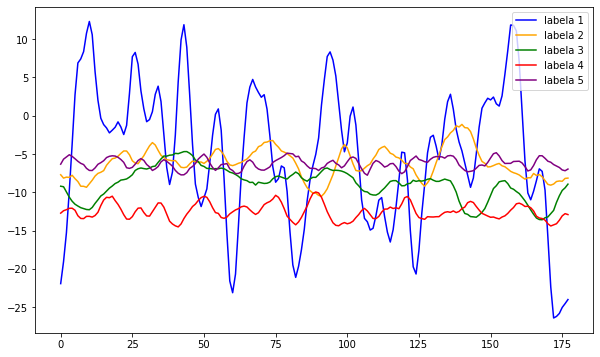

In [17]:
colors = ['blue', 'orange', 'green', 'red', 'purple']
plt.figure(figsize = (10, 6))
for i in range(number_of_classes):
    plt.plot(range(number_of_columns), mean_by_classes.iloc[i,:], c = colors[i], label = 'labela ' + str(i+1))
plt.legend(loc = 'upper right')

In [18]:
std_by_classes = data.groupby(['y']).std()
std_by_classes.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
y,,,,,,,,,,,,,,,,,,,,,
1,342.361939,343.398782,337.489643,332.354833,332.211163,332.941638,332.899545,334.375084,334.534814,331.071853,...,342.095308,341.534693,345.740615,351.503084,351.184524,347.475865,339.650467,335.747017,335.244512,339.819309
2,95.525136,94.734737,93.716055,92.509248,91.004234,90.880780,91.679224,92.097291,91.138175,89.759109,...,92.959490,89.569320,86.961108,86.397728,87.752018,90.156202,92.433147,94.311338,96.013765,96.710559
3,59.924231,60.240543,59.905387,59.697773,59.502204,59.635346,60.043847,59.865027,59.463238,59.110605,...,60.209589,60.715733,60.541729,61.036980,60.658758,60.726974,60.273966,60.178156,59.736182,59.849148
4,69.729925,70.708016,71.425314,71.519947,71.055967,70.532877,70.027232,69.902928,69.674909,69.296696,...,70.359338,70.353789,70.441038,70.135134,69.881104,69.803366,69.846537,70.480867,70.720585,70.646346
5,47.553062,47.903503,48.135729,48.560703,48.568777,48.906275,49.121173,49.197125,48.996716,48.979947,...,47.512691,47.424105,47.793875,47.799416,47.660365,47.505155,47.687482,47.977213,48.238124,48.276043


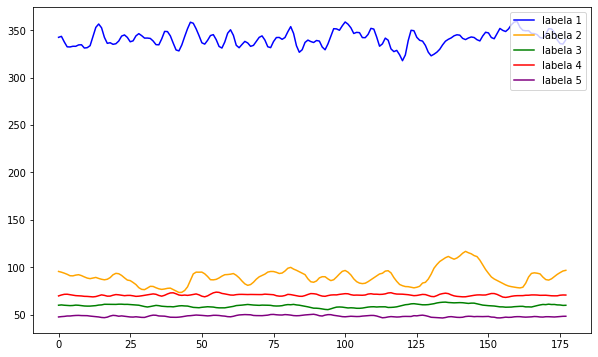

In [19]:
colors = ['blue', 'orange', 'green', 'red', 'purple']
plt.figure(figsize = (10, 6))
for i in range(number_of_classes):
    plt.plot(range(number_of_columns), std_by_classes.iloc[i,:], c = colors[i], label = 'labela ' + str(i+1))
plt.legend(loc = 'upper right')

## Priprema podataka <a class="anchor" id="priprema"></a> 
Sada kada smo se upoznali sa podacima trebalo bi da ih pripremimo za rad sa modelima.   
Međutim, kako i priprema podataka zavisi od načina izbora konfiguracije i evaluacije različitih modela mi to sada nećemo uraditi već ćemo kasnije detaljno objasniti postupak za svaki model posebno. Spomenućemo samo koje smo metode pripreme koristili:  


### Standardizacija podataka:

In [20]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_standardizovano = scaler.transform(X)

Text(0.5, 1.0, 'Standardizovani podaci')

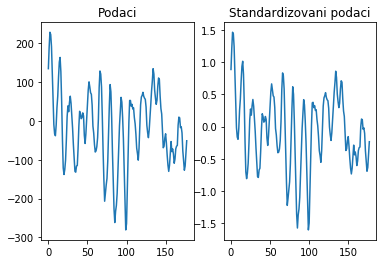

In [21]:
plt.subplot(1,2,1)
plt.plot(np.arange(number_of_columns),  X.iloc[0, :])  
plt.title('Podaci')
plt.subplot(1,2,2)
plt.plot(np.arange(number_of_columns),  X_standardizovano[0, :])  
plt.title('Standardizovani podaci')

### Furijeova transformacija podataka za redukciju dimenzije:

In [22]:
X_fft = np.fft.rfft(X, axis=1).astype(float)
X_fft.shape

C:\Users\vbakarevic\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


(11500, 90)

Text(0.5, 1.0, 'Podaci sa Furijeovom transformacijom')

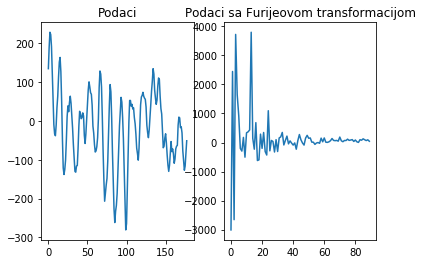

In [23]:
plt.subplot(1,2,1)
plt.plot(np.arange(number_of_columns),  X.iloc[0, :])  
plt.title('Podaci')
plt.subplot(1,2,2)
plt.plot(np.arange(X_fft.shape[1]),  X_fft[0, :])  
plt.title('Podaci sa Furijeovom transformacijom')

Detaljan opis i motivacija za korišćenje Furijeove transformacije može se pronaći u fajlu [Furijeova transformacija](https://github.com/ananikolic96/ML/blob/master/Furijeova%20transformacija.ipynb).

## Klasifikacione metode  <a class="anchor" id="metode"></a>  
U ovom radu upotrebićemo dve klasifikacione metode za identifikaciju moždane aktivnosti, k najbližih suseda i konvolutivne neuronske mreže, jer su se ova dva metoda pokazala kao najuspešnija u dosadašnjim radovima.

## K najbližih suseda <a class="anchor" id="knn"></a>  
Algoritam k najbližih suseda može se primeniti na problem regresije, kao i klasifikacije sa proizvoljnim brojem klasa. Za određivanje vrednosti ciljne promenljive algoritam koristi one instance iz skupa za obučavanje koje su, u prostoru atributa, najbliže tački koju posmatramo. Predviđanje se vrši uprosečavanjem vrednosti zavisne promenljive u slučaju regresije, ili glasanjem u slučaju klasifikacije.

Osnovna pretpostavka algoritma je postojanje mere na prostoru atributa. Najčešće korišćeno rastojanje u primenama, pa tako i u ovom projektu, je Euklidsko.

Parametar k predstavlja broj najbližih suseda koje koristimo za određivanje ciljne promenljive, ali takođe služi i za regularizaciju. Vrednost jedan dovodi do potpunog preprilagođavanja, dok se za veće vrednosti parametra k algoritam sve manje prilagođava podacima.   
<br>
Detaljan proces obučavanja kao i izbor parametra k u slučaju našeg problema mogu se pronaći na sledećoj lokaciji:
[kNN](https://github.com/Vildana96/Projects/blob/master/kNN.ipynb).

### Evaluacija algoritma k najbližih suseda

In [24]:
knn_results = pd.read_csv('kNN_scoring_results.csv')
knn_results

,Unnamed: 0,fit_time,score_time,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy,test_f1_class_1,train_f1_class_1,test_f1_class_2,train_f1_class_2,test_f1_class_3,train_f1_class_3,test_f1_class_4,train_f1_class_4,test_f1_class_5,train_f1_class_5
0,0,317.911174,66.288463,0.490196,0.664568,0.499130,0.674493,0.816327,0.939193,0.496970,0.632617,0.478049,0.679820,0.440789,0.612850,0.218845,0.458362
1,1,322.008723,58.780986,0.484116,0.666664,0.494783,0.676425,0.868293,0.939704,0.470238,0.631542,0.457429,0.688079,0.459016,0.614474,0.165605,0.459523
2,2,326.742123,66.471677,0.476937,0.664131,0.495652,0.673623,0.841310,0.940097,0.507163,0.623930,0.462562,0.686449,0.413115,0.612999,0.160535,0.457181
3,3,324.314962,66.228166,0.488593,0.661262,0.499130,0.671014,0.858561,0.936715,0.479881,0.625612,0.466887,0.679741,0.470968,0.615637,0.166667,0.448604
4,4,325.946957,66.357555,0.504571,0.666485,0.517391,0.676329,0.865526,0.939224,0.499195,0.634752,0.504702,0.683544,0.450980,0.607545,0.202454,0.467359
5,5,327.013980,66.752010,0.496440,0.663365,0.507826,0.672367,0.866995,0.936780,0.477341,0.627128,0.488449,0.679772,0.507937,0.608667,0.141479,0.464477
6,6,328.993591,67.926564,0.472976,0.665337,0.495652,0.674589,0.856448,0.938076,0.468944,0.629324,0.500768,0.680926,0.377104,0.620577,0.161616,0.457782
7,7,131.178351,26.490130,0.466609,0.664920,0.478261,0.674783,0.844444,0.935558,0.455772,0.631764,0.443730,0.684664,0.418605,0.624550,0.170492,0.448065
8,8,129.884472,26.621853,0.457097,0.663826,0.473913,0.674010,0.828283,0.941086,0.458824,0.626908,0.467200,0.686051,0.386441,0.613562,0.144737,0.451525
9,9,130.996178,26.707711,0.484831,0.663200,0.499130,0.672850,0.841310,0.938650,0.480597,0.627617,0.491857,0.682602,0.460064,0.606422,0.150327,0.460712


In [102]:
print('Tačnost na skupu za obučavanje je ', knn_results['train_accuracy'].mean(), 
      ' , a F1 skor je ', knn_results['train_f1_macro'].mean())

Tačnost na skupu za obučavanje je  0.674048309178744  , a F1 skor je  0.6643759363699288


In [103]:
print('Ukupno vreme izvršavanja ugnježđene unakrsne validacije modela je trajalo', 
      (knn_results['fit_time'].sum() + knn_results['score_time'].sum())/3600, 'sati.')

Ukupno vreme izvršavanja ugnježđene unakrsne validacije modela je trajalo 0.8898932299349043 sati.


### Rezultati na testnom skupu

In [110]:
knn_results.mean()[['test_accuracy', 'test_f1_macro', 'test_f1_class_1', 'test_f1_class_2', 'test_f1_class_3', 
                   'test_f1_class_4', 'test_f1_class_5']]

test_accuracy      0.496087
test_f1_macro      0.482237
test_f1_class_1    0.848750
test_f1_class_2    0.479492
test_f1_class_3    0.476163
test_f1_class_4    0.438502
test_f1_class_5    0.168276
dtype: float64

### Evaluacija algoritma k najbližih suseda sa primenom  Furijeove transformacije

In [112]:
knn_fft_results = pd.read_csv('kNN_fft_scoring_results.csv')
knn_fft_results

,Unnamed: 0,fit_time,score_time,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy,test_f1_class_1,train_f1_class_1,test_f1_class_2,train_f1_class_2,test_f1_class_3,train_f1_class_3,test_f1_class_4,train_f1_class_4,test_f1_class_5,train_f1_class_5
0,0,125.100386,24.690894,0.463118,0.676012,0.460870,0.676715,0.786632,0.930328,0.425197,0.611879,0.422259,0.666119,0.460606,0.642767,0.220896,0.528967
1,1,125.619709,24.463188,0.478332,0.676797,0.482609,0.677585,0.830000,0.929780,0.451713,0.615967,0.465195,0.665157,0.474164,0.648513,0.170588,0.524570
2,2,125.548625,24.964564,0.450710,0.669964,0.452174,0.671014,0.827930,0.929339,0.433483,0.606234,0.386087,0.659697,0.394904,0.641711,0.211144,0.512837
3,3,122.418953,23.991990,0.462421,0.674119,0.461739,0.674300,0.851485,0.929982,0.400000,0.610084,0.423012,0.656295,0.466877,0.648886,0.170732,0.525349
4,4,122.992603,23.913206,0.491908,0.675565,0.486957,0.676522,0.828283,0.929852,0.430956,0.615523,0.452962,0.662848,0.482972,0.643714,0.264368,0.525886
5,5,122.960202,23.941294,0.476194,0.673765,0.479130,0.674686,0.849515,0.928791,0.442424,0.611857,0.432143,0.664882,0.445122,0.640304,0.211765,0.522990
6,6,123.917390,24.172017,0.488715,0.670843,0.492174,0.671498,0.871429,0.930090,0.434389,0.607759,0.446397,0.657478,0.487654,0.640856,0.203704,0.518031
7,7,123.690928,24.163566,0.464383,0.673539,0.469565,0.673816,0.830846,0.926667,0.435045,0.607631,0.460733,0.661188,0.360656,0.655022,0.234637,0.517187
8,8,125.701959,24.764277,0.465887,0.674262,0.466087,0.675169,0.802030,0.931458,0.428571,0.612091,0.441739,0.662276,0.384365,0.644918,0.272727,0.520565
9,9,124.886993,24.241044,0.491410,0.672266,0.490435,0.673623,0.835443,0.931423,0.466770,0.612304,0.448336,0.660423,0.469880,0.636536,0.236620,0.520643


In [114]:
print('Tačnost na skupu za obučavanje je ', knn_fft_results['train_accuracy'].mean(), 
      ' , a F1 skor je ', knn_fft_results['train_f1_macro'].mean())

Tačnost na skupu za obučavanje je  0.6744927536231884  , a F1 skor je  0.6737130581432649


In [115]:
print('Ukupno vreme izvršavanja ugnježđene unakrsne validacije modela je trajalo', 
      (knn_fft_results['fit_time'].sum() + knn_fft_results['score_time'].sum())/3600, 'sati.')

Ukupno vreme izvršavanja ugnježđene unakrsne validacije modela je trajalo 0.4128177196449704 sati.


### Rezultati na testnom skupu

In [116]:
knn_fft_results.mean()[['test_accuracy', 'test_f1_macro', 'test_f1_class_1', 'test_f1_class_2', 'test_f1_class_3', 
                   'test_f1_class_4', 'test_f1_class_5']]

test_accuracy      0.474174
test_f1_macro      0.473308
test_f1_class_1    0.831359
test_f1_class_2    0.434855
test_f1_class_3    0.437886
test_f1_class_4    0.442720
test_f1_class_5    0.219718
dtype: float64

## Kovolutivne neuronske mreže <a class="anchor" id="cnn"></a>

U ovom odeljku razvićemo jednodimenzionalnu konvolutivnu neuronsku mrežu (1D CNN).   
Konvolutivne neuronske mreže koriste se najčešće za probleme klasifikacije slika, pri čemu model uči strukturu dvodimenzionalnog ulaza, u procesu koji se naziva učenje atributa (feature learning).  
Isti taj postupak može se koristiti na jednodimenzionalnim nizovima podataka, kao što su u našem slučaju EEG snimci za prepoznavanje ljudske moždane aktivnosti. Model uči da pronalazi atribute iz nizova opservacija sirovih podataka i kako da ih mapira na različite vrste aktivnosti koje treba da prepozna. CNN je neuronska mreža sa slojevima koja koristi klizajuće filtere fiksne dužine za koje pretpostavljamo da su korisni za sekvencijalne podatke zbog njihove invarijantnosti na šiftovanje podataka.  
Uobičajena struktura konvolutivne mreže podrazumeva smenjivanje dve vrste slojeva – konvolutivnih slojeva (convolution layer) i slojeva agregacije (pooling layer). Izlazi konvolutivnih slojeva se transformišu nelinearnom aktivacionom funkcijom. Na izlaze poslednjeg od tih slojeva se obično nadovezuje potpuno povezana mreža.

![](An-illustration-of-one-one-dimensional-1D-cnn.png)

Opisaćemo strukturu konvolutivne neuronske mreže korišćene u našem radu pomoću Keras biblioteke:  
* prvo da napomenemo da model zahteva trodimenzionalni ulaz oblika (broj opservacija, broj atributa, 1), gde 1 predstavlja vremenski korak
* na početku dodajemo dva jednodimenzionalna konvolutivna sloja sa ReLU aktivacionom funkcijom (ispravljena linearna jedinica)
* onda jedan sloj agregacije sa funkcijom maksimuma
* zatim opet slede dva jednodimenzionalna konvolutivna sloja sa ReLU aktivacionom funkcijom samo sada sa dva puta većim filterom
* onda jedan sloj agregacije funkcijom globalnog proseka 
* dodajemo dropout sloj kao način regularizacije izostavljanjem neurona
* na kraju je jedan potpuno povezani sloj sa softmax aktivacionom funkcijom koji kao izlaz vraća verovatnoće pripadanja svakoj od klasa koje predvidjamo 


Kao funkciju greške zadajemo kategoričku unakrsnu entropiju (ciljnu promenljivu posmatramo kao dummy varijablu), a Adam kao provereni optimizacioni algoritam.

In [26]:
def mreza(input_shape, num_classes,window, dropout):
    model = Sequential()
    model.add(Conv1D(filter_cnn, window, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filter_cnn, window, activation='relu'))
    model.add(MaxPooling1D(pool))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(Conv1D(filter_cnn * 2, window, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Detaljan proces obučavanja neuronske mreže kao i vrednosti korišćenih parametara zajedno sa njihovim izborom mogu se pronaći na sledećim lokacijama: [CNN](https://github.com/ananikolic96/ML/blob/master/cnn.ipynb) i [CNN sa Furijeovom transformacijom](https://github.com/Vildana96/Projects/blob/master/cnn_f.ipynb).

### Evaluacija  konvolutivne neuronske mreže 

In [53]:
import joblib
cnn_model = joblib.load("cnn.joblib")

In [54]:
cnn_model.get_params()

{'input_shape': (178, 1),
 'num_classes': 5,
 'window': 15,
 'dropout': 0.1,
 'epochs': 25,
 'build_fn': <function __main__.mreza(input_shape, num_classes, window, dropout)>}

In [55]:
best_params = {'dropout' : cnn_model.get_params()['dropout'], 'window' : cnn_model.get_params()['window']}
best_params

{'dropout': 0.1, 'window': 15}

In [56]:
best_window = best_params['window']
best_dropout = best_params['dropout']

In [59]:
cnn_results = pd.read_csv('raw_cnn_cv_results.csv')
cnn_results.shape

(12, 183)

In [61]:
cnn_model_scores = cnn_results[(cnn_results.param_dropout==best_dropout) &
                                       (cnn_results.param_window==best_window)]
cnn_model_scores

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout,param_window,params,split0_test_f1_macro,split1_test_f1_macro,...,split2_train_f1_class_5,split3_train_f1_class_5,split4_train_f1_class_5,split5_train_f1_class_5,split6_train_f1_class_5,split7_train_f1_class_5,split8_train_f1_class_5,split9_train_f1_class_5,mean_train_f1_class_5,std_train_f1_class_5
2,2,484.809858,4.945256,0.499112,0.011868,0.1,15,"{'dropout': 0.1, 'window': 15}",0.776124,0.794695,...,0.947511,0.948021,0.927242,0.963014,0.906296,0.913465,0.947973,0.948138,0.942388,0.019355


In [62]:
print('Tačnost na trening skupu je ', cnn_model_scores['mean_train_accuracy'].values[0], 
      ', a F1 skor je ', cnn_model_scores['mean_train_f1_macro'].values[0]
)

Tačnost na trening skupu je  0.9180538302277432 , a F1 skor je  0.9176452579755172


In [64]:
print('Ukupno vreme treniranja modela je trajalo', (cnn_results['mean_fit_time'].sum() + cnn_results['mean_score_time'].sum())*10/3600, 'sati.')

Ukupno vreme treniranja modela je trajalo 14.585562719371584 sati.


### Rezultati na testnom skupu

![](cnn_report.PNG)

![](cnn_matrix.PNG)

### Evaluacija  konvolutivne neuronske mreže sa primenom Furijeove transformacije


In [25]:
cnn_fft_model = joblib.load("cnn_fft.joblib")

In [30]:
cnn_fft_model.get_params()

{'input_shape': (90, 1),
 'num_classes': 5,
 'window': 7,
 'dropout': 0.2,
 'epochs': 25,
 'build_fn': <function __main__.mreza(input_shape, num_classes, window, dropout)>}

In [31]:
best_params = {'dropout' : cnn_fft_model.get_params()['dropout'], 'window' : cnn_fft_model.get_params()['window']}
best_params

{'dropout': 0.2, 'window': 7}

In [50]:
best_window = best_params['window']
best_dropout = best_params['dropout']

In [45]:
cnn_fft_results = pd.read_csv('grid_f_cnn_scoring_results.csv')
cnn_fft_results.shape

(9, 183)

In [81]:
cnn_fft_model_scores = cnn_fft_results[(cnn_fft_results.param_dropout==best_dropout) &
                                       (cnn_fft_results.param_window==best_window)]
cnn_fft_model_scores

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout,param_window,params,split0_test_f1_macro,split1_test_f1_macro,...,split2_train_f1_class_5,split3_train_f1_class_5,split4_train_f1_class_5,split5_train_f1_class_5,split6_train_f1_class_5,split7_train_f1_class_5,split8_train_f1_class_5,split9_train_f1_class_5,mean_train_f1_class_5,std_train_f1_class_5
4,4,272.529417,7.798654,6.412987,0.259565,0.2,7,"{'dropout': 0.2, 'window': 7}",0.737678,0.772217,...,0.974429,0.923669,0.950544,0.969655,0.95992,0.978402,0.969656,0.964965,0.958815,0.01606


In [98]:
print('Tačnost na trening skupu je ', cnn_fft_model_scores['mean_train_accuracy'].values[0], 
      ', a F1 skor je ', cnn_fft_model_scores['mean_train_f1_macro'].values[0]
)

Tačnost na trening skupu je  0.901559696342305 , a F1 skor je  0.9010647972918822


In [99]:
print('Ukupno vreme treniranja modela je trajalo', (cnn_fft_results['mean_fit_time'].sum() + cnn_fft_results['mean_score_time'].sum())*10/3600, 'sati.')

Ukupno vreme treniranja modela je trajalo 6.989320650630525 sati.


### Rezultati na testnom skupu

![](cnn_fft_report.PNG)

![](cnn_fft_matrix.PNG)

## Rezultati <a class="anchor" id="rezultati"></a>  
U sledećoj tabeli sumirani su rezultati svih spomenutih metoda sa i bez upotrebe Furijeove transformacije podataka. Kao meru za evaluaciju koristili smo tačnost predviđanja, F1 skor kao i njegove vrednosti po klasama. Takođe, treba napomenuti da rezultati za algoritam k najbližih suseda i konvolutivne neuronske mreže nisu dobijeni na isti način, jer smo prvi metod evaluirali ugnježđenom unakrsnom validacijom dok smo za drugi to uradili na testnom skupu.

![](rezultati.PNG)

## Zaključak <a class="anchor" id="zaključak"></a>  

Iz prethodne tabele sa rezultatima vidimo da konvultivna neuronska mreža postiže značajno bolje rezultate od algoritma k najbližih suseda. Možemo primetiti da postoji veoma mala razlika u performansama oba modela sa i bez Furijeove transformacije dok je, kao što je gore spomenuto, vreme obučavanja modela znatno kraće kada se primeni Furijeova transformacija, što opravdava prvobitnu ideju za njeno korišćenje. Takođe, primetimo da je F1 skor za klasu 1 - epileptički napad, primetno bolji nego za ostale klase što znači da klasu 1 dobro razdvajamo od ostalih i pri tome pravimo najmanju grešku pri identifikaciji epiliptičke moždane aktivnosti, a to je bio i cilj rada.  
Kao što se vidi iz priloženih rezultata, postoji određeno preprilagođavanje svih modela podacima. Taj problem smo pokušali da otklonimo podešavanjem regularizacionih parametara kod konvolutivne neuronske mreže ([CNN_sa_regularizacijom](https://github.com/Vildana96/Projects/blob/master/cnn_f_reg.ipynb)), međutim smanjenjem preprilagođavanja dobili smo i nešto slabije rezultate modela. Svakako, ovo je tema za budući rad i istraživanje. 

## Literatura <a class="anchor" id="ref"></a>

* [Data](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition)
* [Identifying Brain Activity from EEG Recordings](http://cs229.stanford.edu/proj2019aut/data/assignment_308832_raw/26578343.pdf)
* [Fourier Transformation for a Data Scientist](https://medium.com/swlh/fourier-transformation-for-a-data-scientist-1f3731115097 )
* [Indications of nonlinear deterministic and finite-dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state](https://www.researchgate.net/publication/11620616_Indications_of_nonlinear_deterministic_and_finite-dimensional_structures_in_time_series_of_brain_electrical_activity_Dependence_on_recording_region_and_brain_state)
* [Epileptic Seizure Detection Based on EEG Signals and CNN](https://www.frontiersin.org/articles/10.3389/fninf.2018.00095/full)
* [Diskretne transformacije
signala, primene i algoritmi](https://matematika.pmf.uns.ac.rs/wp-content/uploads/zavrsni-radovi/primenjena_matematika/KatarinaKovacevic.pdf)
* [FURIJEOVA TRANSFORMACIJA ](https://dsp.etfbl.net/tek2/aoks/09%20Glava%206%20Furijeova%20transformacija.pdf)
* [Learning Rate Tuning in Deep Learning: A Practical Guide](https://mlexplained.com/2018/01/29/learning-rate-tuning-in-deep-learning-a-practical-guide/#:~:text=One%20is%20that%20larger%20learning,acts%20as%20an%20implicit%20regularizer.&text=If%20you%20find%20your%20model,the%20model%20to%20generalize%20poorly.)
* [How to Develop 1D Convolutional Neural Network Models for Human Activity Recognition](https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/)
* [Keras Conv1D: Working with 1D Convolutional Neural Networks in Keras](https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/)